# Practical machine learning and deep learning. Lab 1
# Tools and Processes for Machine Learning and Data Analysis

## [Competition](https://www.kaggle.com/t/fa8bbded119a4cb6a0f5b92601a2122a)

### Goal
Labs will be conducted with use of [Kaggle](https://www.kaggle.com). 

The aim of today's lab is to find out how the next labs will be held and recap ML workflow.

Also, you have two tasks: 1) recap the training flow of a neural network and 2) use a traking tool to control this flow. 

### Submission
Your are asked to implement a neural network to classify if there is a person with blond hairs on a photo and generate `submission.csv` for the test set.

## Frameworks we're using in this lab

#### PyTorch
   PyTorch is an open-source machine learning library primarily developed by Meta's (компания признана экстремистской организацией на территории Российской Федерации) AI Research lab . It is widely used for deep learning tasks.

#### Tensorboard
   TensorBoard is a visualization tool provided by TensorFlow for monitoring and visualizing the training process and model performance during machine learning experiments.


#### ClearML
   ClearML is an open-source machine learning platform designed to automate and streamline the end-to-end machine learning workflow, including data management, model training, and deployment.

In [4]:
# We will use tensorboard as logging tool. However kaggle does not allow to view it.
!pip install tensorboard


/Users/dmitry057/Projects/Innopolis/PML/.venv/bin/pip: line 2: /Users/dmitry057/Projects/Practical Machine Learning/.venv/bin/python: No such file or directory
/Users/dmitry057/Projects/Innopolis/PML/.venv/bin/pip: line 2: exec: /Users/dmitry057/Projects/Practical Machine Learning/.venv/bin/python: cannot execute: No such file or directory


In [3]:
import warnings
warnings.filterwarnings("ignore")

## 1. Data set

Data set, a part of [CelebA](https://www.kaggle.com/datasets/jessicali9530/celeba-dataset/data), contain about 11,000 cropped images of faces. Your task is to detect people with blond hairs or do binary classification (blondy\not blondy) for each image.

There are several small challenges you're going to face with the dataset. First, the images are much bigger than in regular learning sets—178 by 218 pixels in RGB scale. Second, the CelebA dataset is quite well- labelled, and each image has lots of metadata about face features. Usually, they are used to train generative or face recognition models. We intentionally left all of these features, which are redundant for solving this task.

Please do not train a classifier on other data than given (including other parts of CelebA).


## 1.1 Data preprocessing

In [2]:
# necessary imports

!which python


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from tqdm.notebook import tqdm

from torch.utils.tensorboard import SummaryWriter

import torchvision.transforms as transforms
from torchvision.io import read_image

/Users/dmitry057/Projects/Innopolis/PML/.venv/bin/python


In [18]:

def load_img(fname):
    """
    Load an image from file, do transformation (including possible augmentation) and return it as torch.tensor

    :param fname: path to jpg image
    """
    img = read_image(fname)
    x = img / 255.
    
    # Write your code here
    transform = transforms.Compose(
        [
            #   Here you can add more augmentations.
            #   See documentation: https://pytorch.org/vision/stable/transforms.html
        ]
    )

    return transform(x)

In [19]:
img_path = "archive"

# Image attributes
train_features = pd.read_csv(f"{img_path}/train.csv")

# Load and transform images 
images = torch.stack([load_img(f"{img_path}/img_align_celeba/train/{item['image_id']}") for _, item in  train_features.iterrows()])

# Write your code here
# Select label(s) from train_features
target_cols = [
    "Blond_Hair",
    # add any others from your header…
]
missing = set(target_cols) - set(train_features.columns)
assert not missing, f"Missing columns in train.csv: {missing}"

# Map -1→0 for all selected attributes and convert to float tensor [N, K]
labels = (
    train_features[target_cols]
    .replace({-1: 0})
    .astype("float32")
)
labels = torch.tensor(labels.to_numpy(), dtype=torch.float32)


In [20]:
# Just some checking of shapes
images.shape, labels.shape

(torch.Size([11785, 3, 218, 178]), torch.Size([11785, 1]))

## 1.2 Visualization

In [21]:

import matplotlib.pyplot as plt


def plot_images(images, captions=[], rows=2, columns=5, title="", **kwargs):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(6, 3))
    for i, img in enumerate(images):
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img, **kwargs)
        if i < len(captions):
            plt.title(captions[i])
        plt.axis("off")
    fig.suptitle(title)
    plt.show()

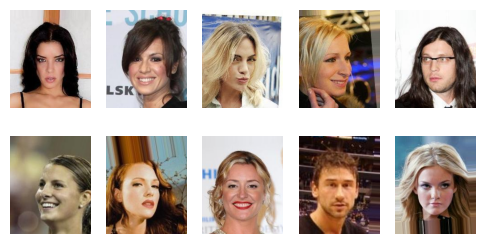

In [9]:
# Visualise 10 images from the dataset
plot_images(images[:10].permute((0, 2, 3, 1)), cmap="gray")


## 1.3 Data loaders creation

In [22]:
from torch.utils.data import TensorDataset, DataLoader

processed_dataset = TensorDataset(images, labels)

# Write your code here
# Set proportion and split dataset into train and validation parts
proportion = 0.8

train_dataset, val_dataset = torch.utils.data.random_split(
    processed_dataset,
   [(int(len(images) * proportion)), len(images) - int(len(images) * proportion)],
)


In [23]:
# Create Dataloaders for training and validation 
# Dataloader is iterable object over dataset
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


## 2. Training


## 2.1 Defining a model

We will implement CNN

> if you want higher score implement any suitable model you know and like

Check Pytorch [documentation](https://pytorch.org/docs/stable/nn.html): layers, loss functions, etc

In [24]:
import torch
import torch.nn as nn

class CNNClassificationModel(nn.Module):
    """
    CNN (convolutional neural network) based classification model

    param num_classes: number of labels you predict (e.g., len(target_cols))
    """
    def __init__(self, num_classes: int):
        super().__init__()

        def conv_block(in_ch, out_ch, k=3, s=1, p=1):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=k, stride=s, padding=p, bias=False),
                nn.BatchNorm2d(out_ch),
                nn.ReLU(inplace=True),
            )

        # 3xH x W input expected; adjust first in_ch if you use grayscale
        self.features = nn.Sequential(
            conv_block(3,   32),              # -> 32 x H x W
            conv_block(32,  32),
            nn.MaxPool2d(2),                  # downsample /2

            conv_block(32,  64),
            conv_block(64,  64),
            nn.MaxPool2d(2),                  # /2

            conv_block(64, 128),
            conv_block(128,128),
            nn.MaxPool2d(2),                  # /2

            conv_block(128,256),
            nn.MaxPool2d(2),                  # /2
        )

        # make spatial size 1x1 regardless of input size
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),         # -> C x 1 x 1 (size-agnostic). 
            nn.Flatten(),                     # -> C
            nn.Dropout(p=0.2),
            nn.Linear(256, num_classes)       # raw logits for BCEWithLogitsLoss
        )

        # expose one Sequential for forward()
        self.model = nn.Sequential(self.features, self.head)

    def forward(self, x):
        return self.model(x)


## 2.2 Defining training & validation loops

Here is the sample function for training procedure. 
We save the checkpoints with best accuracy score. For the inference you need to load it to the model.

> You can add early stopping if you want for better results

In [28]:
def train(
    model,
    optimizer,
    loss_fn,
    train_loader,
    val_loader,
    writer=None,
    epochs=1,
    device="cpu",
    ckpt_path="best.pt",
):
    best = 0.0
    model.to(device)

    for epoch in range(epochs):
        # -------- Training --------
        model.train()
        train_loop = tqdm(enumerate(train_loader, 0), total=len(train_loader), desc=f"Epoch {epoch}")
        train_loss = 0.0

        for _, (inputs, labels) in train_loop:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()                           # reset grads
            logits = model(inputs)                          # forward
            loss = loss_fn(logits, labels)                  # compute loss
            loss.backward()                                 # backprop
            optimizer.step()                                # update params

            train_loss += loss.item()
            train_loop.set_postfix({"loss": loss.item()})

        if writer:
            writer.add_scalar("Loss/train", train_loss / len(train_loader), epoch)

        # -------- Validation --------
        model.eval()
        correct = 0
        total = 0

        with torch.no_grad():                               # no grad for eval
            val_loop = tqdm(enumerate(val_loader, 0), total=len(val_loader), desc="Val")
            for _, (inputs, labels) in val_loop:
                inputs = inputs.to(device)
                labels = labels.to(device)

                logits = model(inputs)

                # --- Accuracy for different target types ---
                # Case A: Multiclass (targets: [B], dtype long; logits: [B, C])
                if labels.dtype in (torch.long, torch.int64) and logits.ndim == 2 and labels.ndim == 1:
                    preds = logits.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)

                else:
                    # Binary or Multilabel (targets float 0/1; logits: [B] or [B, K])
                    probs = torch.sigmoid(logits)
                    preds = (probs >= 0.5).to(labels.dtype)

                    if labels.ndim == 1 or labels.shape[-1] == 1:
                        # Binary: compare per-sample
                        correct += (preds.view(-1) == labels.view(-1)).sum().item()
                        total += labels.numel()
                    else:
                        # Multilabel: average per-label accuracy across batch
                        correct += (preds == labels).sum().item()
                        total += labels.numel()

                val_loop.set_postfix({"acc": correct / max(total, 1)})

        val_acc = correct / max(total, 1)
        if writer:
            writer.add_scalar("Acc/val", val_acc, epoch)

        if val_acc > best:
            torch.save(model.state_dict(), ckpt_path)
            best = val_acc

## 2.3 Combining everything together

In [ ]:
# Write your code here
# Pick optimizer from torch.optim and loss function loss_fn from torch.nn that suits best the model
# SummaryWriter is used by tensorboard and could be set None
# num_classes = number of selected attributes (columns) in `labels`
model = CNNClassificationModel(num_classes=labels.shape[1])

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=5e-5)  # decreased lr and weight_decay
loss_fn  = nn.BCEWithLogitsLoss()  # multi-label: independent 0/1 per class

train(
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    train_loader=train_loader,
    val_loader=val_loader,
    device='mps',                     # or 'mps' on Apple Silicon / 'cuda' if available
    writer=SummaryWriter(),           # TensorBoard logger
    epochs=2
)


Epoch 0:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

Epoch 3:   0%|          | 0/148 [00:00<?, ?it/s]

Val:   0%|          | 0/37 [00:00<?, ?it/s]

## 2.4 Inference
Here you need to perform inference of trained model on test data. 

Load the best checkpoint from training to the model and run inference

In [39]:
# load best checkpoint to model
 
model = CNNClassificationModel(labels.shape[1])
ckpt = torch.load("best.pt")
model.load_state_dict(ckpt)

<All keys matched successfully>

In [40]:
import torch
from torchvision.io import read_image
from torchvision import transforms

def predict(model, test_loader, device):
    """
    Run model inference on test data (multi-label default).
    Returns a Python list of numpy arrays per batch (or flatten to taste).
    """
    predictions = []
    model.eval()
    with torch.no_grad():  # disable autograd for speed/memory
        test_loop = tqdm(enumerate(test_loader, 0), total=len(test_loader), desc="Test")
        for _, batch in test_loop:
            # batch can be either just inputs, or (inputs, labels). Handle both.
            if isinstance(batch, (list, tuple)) and len(batch) == 2:
                inputs, _ = batch
            else:
                inputs = batch

            inputs = inputs.to(device)
            logits = model(inputs)                  # raw scores
            probs = torch.sigmoid(logits)           # convert to [0,1]
            pred = (probs >= 0.5).to(torch.float32) # binarize at 0.5 (common default)

            # extend with CPU numpy arrays for generality
            predictions.extend(pred.cpu().numpy())
    return predictions

# --- Option B: You trained with ImageNet normalization (common for pretrained models) ---
# Apply the same mean/std at test time.
def load_training_img(fname, size=224):
    img = read_image(fname)  # uint8 CxHxW
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ConvertImageDtype(torch.float32),          # -> [0,1]
        transforms.Normalize(mean=[0.485, 0.456, 0.406],      # ImageNet stats
                             std=[0.229, 0.224, 0.225]),
    ])
    x = transform(img)
    return x

In [41]:
# process test data and run inference on it
test_features = pd.read_csv(f"{img_path}/test.csv")
images = torch.stack([load_img(f"{img_path}/img_align_celeba/test/{item['image_id']}") for _, item in  test_features.iterrows()])

test_loader = DataLoader(images, batch_size=batch_size, shuffle=False)
import torch

# pick a device once
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")

# 1) Recreate model with the correct head size
num_classes = labels.shape[1]  # or 1 if single label
model = CNNClassificationModel(num_classes=num_classes)

# 2) Load checkpoint onto the right device
ckpt = torch.load("best.pt", map_location=device)
model.load_state_dict(ckpt)

# 3) Move model to device (must match your inputs)
model.to(device)

# 4) Inference (your predict() already does inputs.to(device))
predictions = predict(model, test_loader, device=device)

# flatten predictions from e.g. [[1.0], [0.0], ...] to [1.0, 0.0, ...]
flat_predictions = [float(p[0]) if isinstance(p, (list, np.ndarray)) or (hasattr(p, '__len__') and not isinstance(p, (str, bytes))) else float(p) for p in predictions]

# generate the submission file
submission_df = pd.DataFrame(columns=['ID', 'Blond_Hair'])
submission_df['ID'] = test_features.index
submission_df['Blond_Hair'] = flat_predictions
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

Test:   0%|          | 0/16 [00:00<?, ?it/s]

,ID,Blond_Hair
0,0,1.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,0.0


## 3 Training tracking - [ClearML](https://clear.ml/docs/latest/docs/getting_started/ds/ds_first_steps/) or Tensorboard

In [30]:
# Kaggle has no support of viewing tensorboard. Run this if you are using your machine
# to see logs.
!tensorboard --logdir . 

TensorFlow installation not found - running with reduced feature set.
Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.20.0 at http://localhost:6006/ (Press CTRL+C to quit)


OSError: [Errno 5] Input/output error

Tensorboard should like this
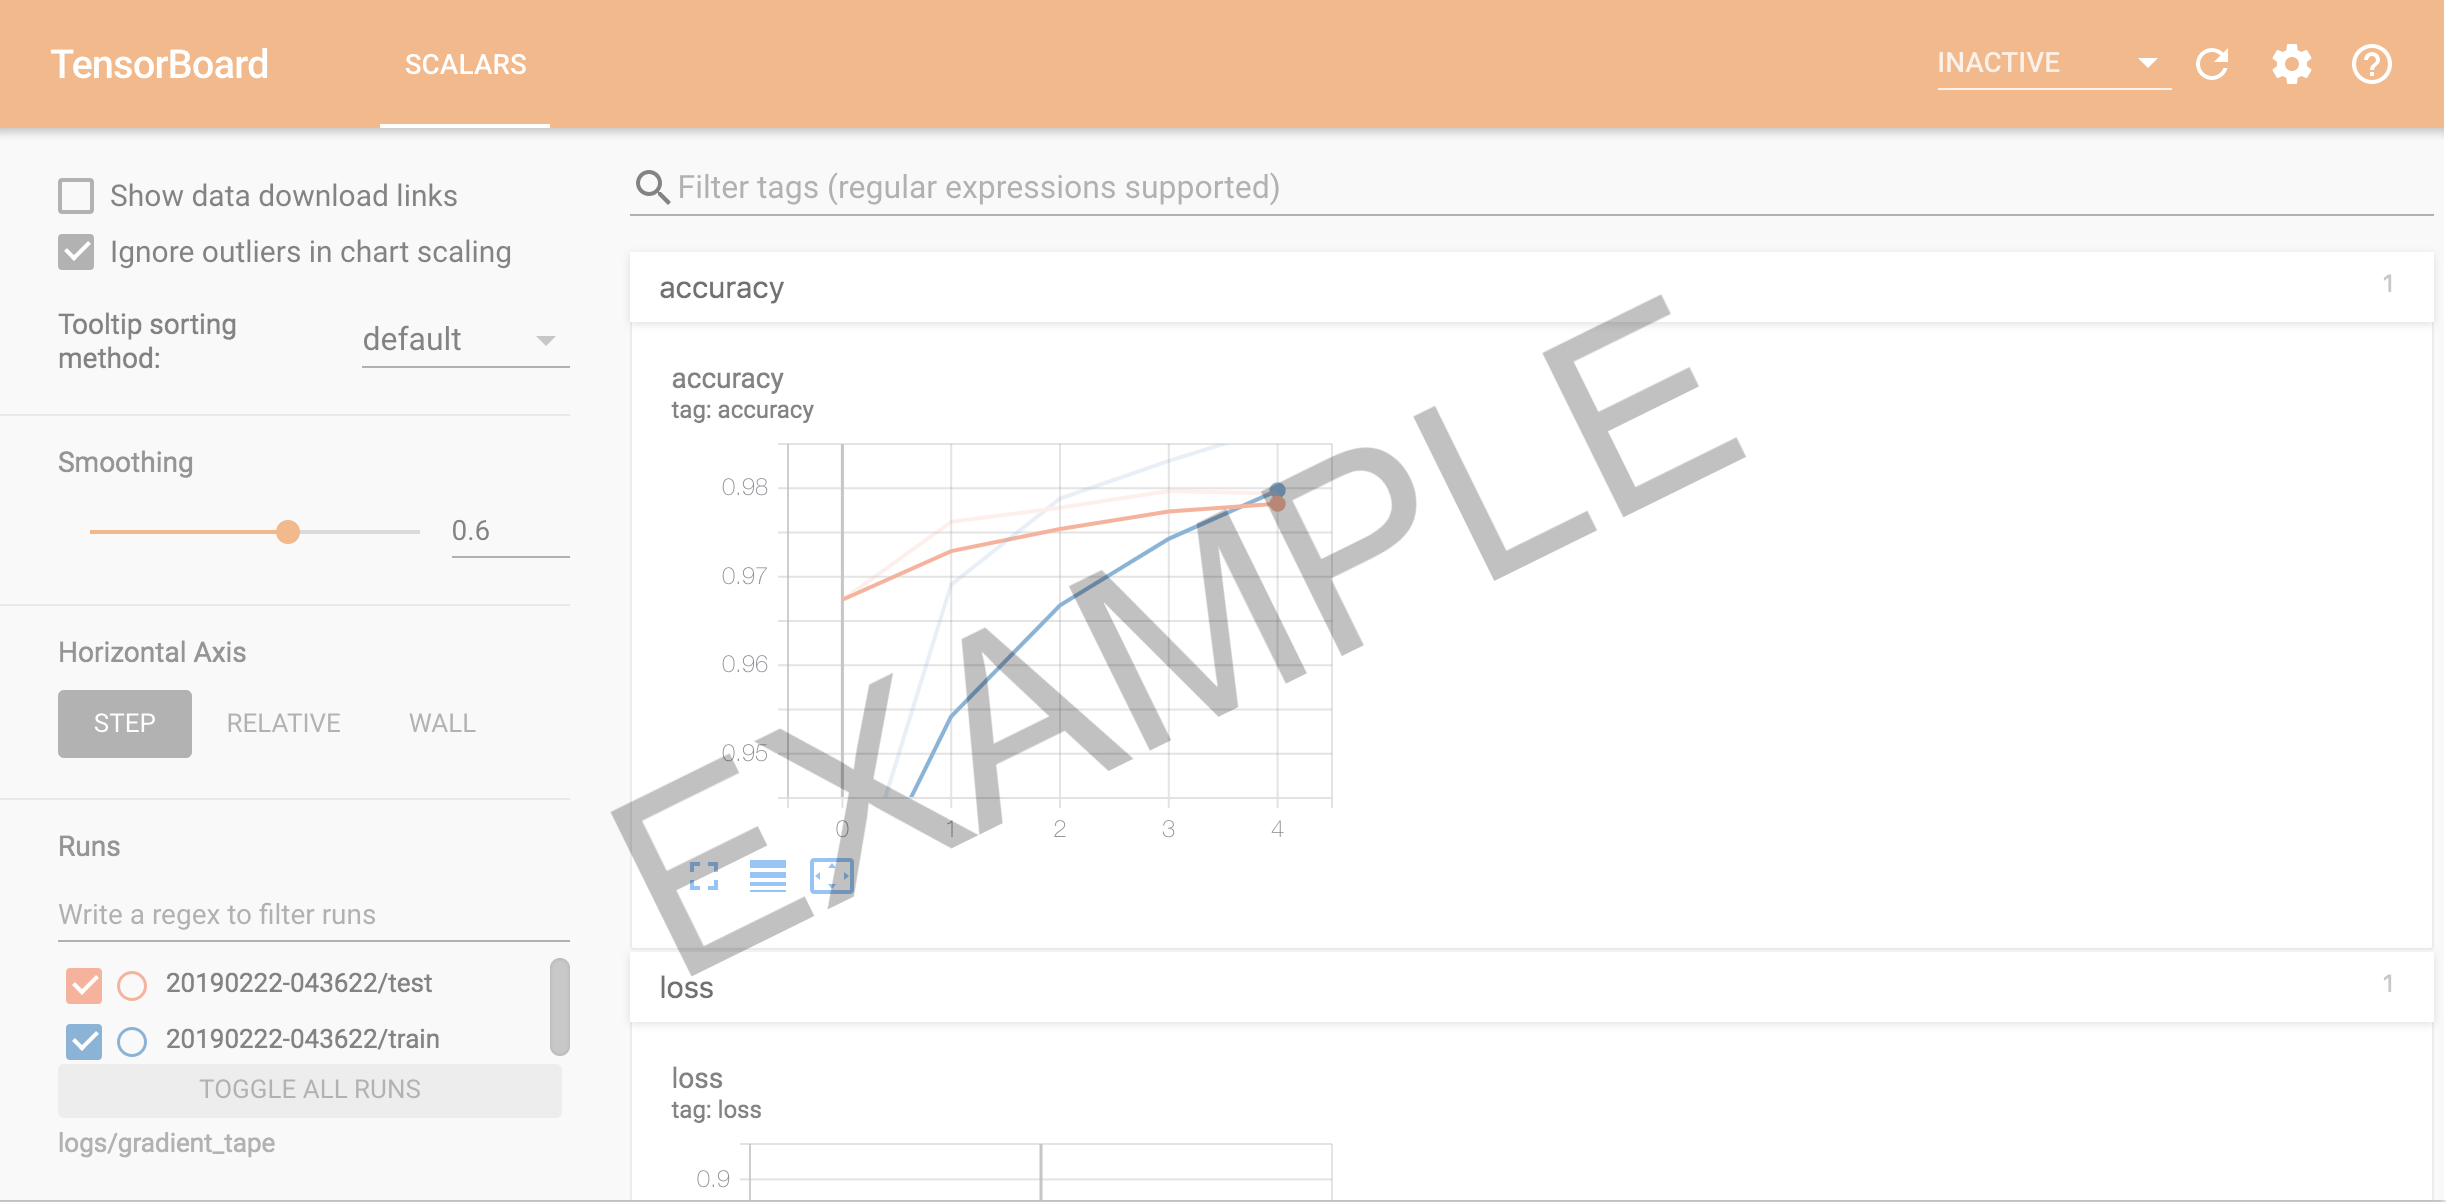

#### Configuring ClearML

1) Sign up in  [ClearMl](https://clear.ml)
2) Install clearml as python package: pip install clearml
3) Get [credentials](https://app.clear.ml/settings/workspace-configuration) to connect your notebook with remote server. When creating new credentials, pick Jupyter notebook tab.  
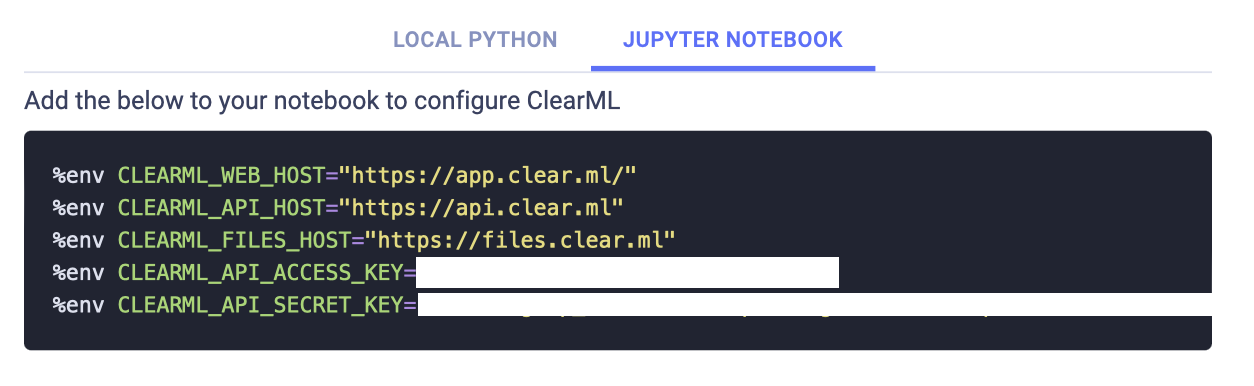
4) Put these env variables 
5) Run !clearml-init
6) Uncomment code in the next cell 

In [31]:
%pip install clearml
!clearml-init


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 3.4 MB/s eta 0:00:00a 0:00:010m

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
ClearML SDK setup process
Configuration file already exists: /Users/dmitry057/clearml.conf
Leaving setup, feel free to edit the configuration file.


In [32]:
# Run this cell to start monitoring the training
from clearml import Task

task = Task.init(task_name="classifier_training", project_name="pmldl-lab1")

ClearML Task: created new task id=06dacad3352f4e7db867f4ae4f3a6935
2025-08-27 14:31:48,651 - clearml.Task - INFO - Storing jupyter notebook directly as code
2025-08-27 14:31:48,684 - clearml.Repository Detection - WARNING - Can't get url information for git repo in /Users/dmitry057/Projects/Practical Machine Learning
2025-08-27 14:31:48,744 - clearml.Repository Detection - WARNING - Can't get branch information for git repo in /Users/dmitry057/Projects/Practical Machine Learning
2025-08-27 14:31:48,788 - clearml.Repository Detection - WARNING - Can't get commit information for git repo in /Users/dmitry057/Projects/Practical Machine Learning
2025-08-27 14:31:48,938 - clearml.Repository Detection - WARNING - Can't get diff information for git repo in /Users/dmitry057/Projects/Practical Machine Learning
ClearML results page: https://clearml.touchtopnotch.com/projects/6d844f988e6c4e3b8892ecfe073ce160/experiments/06dacad3352f4e7db867f4ae4f3a6935/output/log
CLEARML-SERVER new package availab

ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


Retrying (Retry(total=237, connect=238, read=239, redirect=240, status=240)) after connection broken by 'NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x152aa1ae0>: Failed to resolve 'api.clearml.touchtopnotch.com' ([Errno 8] nodename nor servname provided, or not known)")': /v2.23/tasks.ping


In [33]:
# try again and check Web UI...
"""
train(
    model=CNNClassificationModel(),
    optimizer=...,
    loss_fn=...,
    train_loader=train_loader,
    val_loader=val_loader,
    device='cpu',
    writer=SummaryWriter(),
    epochs=2
)
"""

"\ntrain(\n    model=CNNClassificationModel(),\n    optimizer=...,\n    loss_fn=...,\n    train_loader=train_loader,\n    val_loader=val_loader,\n    device='cpu',\n    writer=SummaryWriter(),\n    epochs=2\n)\n"

2025-08-27 15:05:22,283 - clearml.storage - ERROR - Exception encountered while uploading ('Connection aborted.', ConnectionResetError(54, 'Connection reset by peer'))


ClearMl results look like this

![board.png](board.png)